In [ ]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# API setup
TOKEN = "a17d44d2afcb4ded8f2c90c9db9d59cc"
HEADERS = {"X-Auth-Token": TOKEN}
BASE = "https://api.football-data.org/v4"

def get_matches(season):
    url = f"{BASE}/competitions/PL/matches?season={season}"
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()["matches"]

In [ ]:
# Build training dataset (2023–2024)
data = []

for s in [2023, 2024]:
    for m in get_matches(s):
        if m["status"] == "FINISHED":
            data.append({
                "date": m["utcDate"],
                "home": m["homeTeam"]["name"],
                "away": m["awayTeam"]["name"],
                "hg": m["score"]["fullTime"]["home"],
                "ag": m["score"]["fullTime"]["away"]
            })

In [ ]:
df = pd.DataFrame(data).sort_values("date").reset_index(drop=True)

In [ ]:
# Result encoding
def get_res(r):
    if r.hg > r.ag:
        return 0
    elif r.hg < r.ag:
        return 1
    else:
        return 2

df["res"] = df.apply(get_res, axis=1)

In [ ]:
# Team form features (rolling)
def teams_form(df, w=5):
    teams = pd.unique(df[["home", "away"]].values.ravel())
    hist = {t: [] for t in teams}
    rows = []

    for _, r in df.iterrows():
        h, a = r.home, r.away

        hf = hist[h][-w:]
        af = hist[a][-w:]

        rows.append({
            "h_gf": np.mean([x[0] for x in hf]) if hf else 0,
            "h_ga": np.mean([x[1] for x in hf]) if hf else 0,
            "a_gf": np.mean([x[0] for x in af]) if af else 0,
            "a_ga": np.mean([x[1] for x in af]) if af else 0
        })

        hist[h].append((r.hg, r.ag))
        hist[a].append((r.ag, r.hg))

    return pd.concat([df, pd.DataFrame(rows)], axis=1)

In [ ]:
df = teams_form(df)

In [ ]:
# Train / validation split
feat = ["h_gf", "h_ga", "a_gf", "a_ga"]
X = df[feat].values
y = df["res"].values

sc = StandardScaler()
X = sc.fit_transform(X)

Xtr, Xva, ytr, yva = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Dataset + model
class MatchDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class Net(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Train model
train_dl = DataLoader(MatchDS(Xtr, ytr), batch_size=32, shuffle=True)
val_dl = DataLoader(MatchDS(Xva, yva), batch_size=256)

model = Net(X.shape[1])
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for e in range(20):
    model.train()
    tot = 0
    for xb, yb in train_dl:
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        tot += loss.item()
    print(f"Epoch {e+1} | Loss {tot/len(train_dl):.4f}")

Epoch 1 | Loss 1.0745
Epoch 2 | Loss 1.0365
Epoch 3 | Loss 1.0159
Epoch 4 | Loss 1.0019
Epoch 5 | Loss 0.9959
Epoch 6 | Loss 0.9936
Epoch 7 | Loss 0.9897
Epoch 8 | Loss 0.9873
Epoch 9 | Loss 0.9864
Epoch 10 | Loss 0.9835
Epoch 11 | Loss 0.9813
Epoch 12 | Loss 0.9800
Epoch 13 | Loss 0.9782
Epoch 14 | Loss 0.9763
Epoch 15 | Loss 0.9749
Epoch 16 | Loss 0.9733
Epoch 17 | Loss 0.9708
Epoch 18 | Loss 0.9704
Epoch 19 | Loss 0.9682
Epoch 20 | Loss 0.9657


Accuracy: 0.5131578947368421


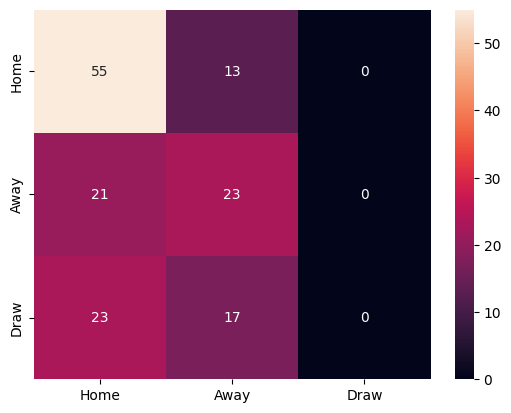

In [ ]:
# Evaluate
model.eval()
preds, true = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        p = model(xb).argmax(1)
        preds.extend(p.numpy())
        true.extend(yb.numpy())

acc = accuracy_score(true, preds)
print("Accuracy:", acc)

cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Home","Away","Draw"],
            yticklabels=["Home","Away","Draw"])
plt.show()

In [ ]:
# Fetch 2025/26 matches
data_25 = []

for m in get_matches(2025):
    data_25.append({
        "date": m["utcDate"],
        "home": m["homeTeam"]["name"],
        "away": m["awayTeam"]["name"],
        "hg": m["score"]["fullTime"]["home"],
        "ag": m["score"]["fullTime"]["away"],
        "status": m["status"]
    })

In [ ]:
# CHECK THE DATA
print(f"Total 2025 matches: {len(df25)}")
print(f"\nStatus breakdown:")
print(df25['status'].value_counts())
print(f"\nFirst 5 rows:")
print(df25.head())
print(f"\nLast 5 rows:")
print(df25.tail())

Total 2025 matches: 380

Status breakdown:
status
FINISHED    210
TIMED       170
Name: count, dtype: int64

First 5 rows:
                   date                       home                 away   hg  \
0  2025-08-15T19:00:00Z               Liverpool FC      AFC Bournemouth  4.0   
1  2025-08-16T11:30:00Z             Aston Villa FC  Newcastle United FC  0.0   
2  2025-08-16T14:00:00Z  Brighton & Hove Albion FC            Fulham FC  1.0   
3  2025-08-16T14:00:00Z             Sunderland AFC   West Ham United FC  3.0   
4  2025-08-16T14:00:00Z       Tottenham Hotspur FC           Burnley FC  3.0   

    ag    status  
0  2.0  FINISHED  
1  0.0  FINISHED  
2  1.0  FINISHED  
3  0.0  FINISHED  
4  0.0  FINISHED  

Last 5 rows:
                     date                       home  \
375  2026-05-24T15:00:00Z          Crystal Palace FC   
376  2026-05-24T15:00:00Z  Brighton & Hove Albion FC   
377  2026-05-24T15:00:00Z             Sunderland AFC   
378  2026-05-24T15:00:00Z                 Bu

In [ ]:
df25 = pd.DataFrame(data_25).sort_values("date").reset_index(drop=True)

In [ ]:
# Split played vs future
played = df25[df25.status == "FINISHED"].copy()
future = df25[df25.status == "TIMED"].copy()

print(f"\nPlayed games: {len(played)}")
print(f"Future games: {len(future)}")


Played games: 210
Future games: 170


In [ ]:
# Get ONLY base columns (no form features, no extra columns)
base_cols = ['date', 'home', 'away', 'hg', 'ag']

df_base = df[base_cols].copy()
played_base = played[base_cols].copy()

In [ ]:
# Create future temp with dummy scores
future_temp = future[['date', 'home', 'away']].copy()
future_temp['hg'] = 0
future_temp['ag'] = 0

In [ ]:
# Concatenate ALL games BEFORE calculating form
all_games = pd.concat([df_base, played_base, future_temp], ignore_index=True)

In [ ]:
print(f"Before teams_form - all_games shape: {all_games.shape}")
print(f"Before teams_form - columns: {all_games.columns.tolist()}")

Before teams_form - all_games shape: (1140, 5)
Before teams_form - columns: ['date', 'home', 'away', 'hg', 'ag']


In [ ]:
# NOW calculate form once for everything
all_games = teams_form(all_games)

print(f"After teams_form - all_games shape: {all_games.shape}")
print(f"After teams_form - columns: {all_games.columns.tolist()}")

After teams_form - all_games shape: (1140, 9)
After teams_form - columns: ['date', 'home', 'away', 'hg', 'ag', 'h_gf', 'h_ga', 'a_gf', 'a_ga']


In [ ]:
# Get features only for future games (last len(future) rows)
future_feat = all_games.iloc[-len(future):][feat].values

print(f"future_feat shape: {future_feat.shape}")  # Should be (170, 4)

future_feat shape: (170, 4)


In [ ]:
future_feat = sc.transform(future_feat)

In [ ]:
# Predict remaining matches
model.eval()
with torch.no_grad():
    probs = torch.softmax(
        model(torch.tensor(future_feat, dtype=torch.float32)), 1
    ).numpy()

future["p_home"] = probs[:,0]
future["p_away"] = probs[:,1]
future["p_draw"] = probs[:,2]

print("\nSample predictions:")
print(future[['home', 'away', 'p_home', 'p_draw', 'p_away']].head(10))


Sample predictions:
                           home                 away    p_home    p_draw  \
210        Manchester United FC   Manchester City FC  0.304343  0.218544   
211        Tottenham Hotspur FC   West Ham United FC  0.539598  0.299179   
212             Leeds United FC            Fulham FC  0.441170  0.270625   
213                  Chelsea FC         Brentford FC  0.205261  0.159626   
214              Sunderland AFC    Crystal Palace FC  0.408853  0.244714   
215                Liverpool FC           Burnley FC  0.507786  0.247784   
216        Nottingham Forest FC           Arsenal FC  0.198256  0.153603   
217  Wolverhampton Wanderers FC  Newcastle United FC  0.375759  0.256096   
218              Aston Villa FC           Everton FC  0.456215  0.279523   
219   Brighton & Hove Albion FC      AFC Bournemouth  0.540976  0.293074   

       p_away  
210  0.477113  
211  0.161223  
212  0.288205  
213  0.635112  
214  0.346433  
215  0.244430  
216  0.648142  
217  0.368145 

In [ ]:
# Monte-Carlo league simulation
teams = pd.unique(df25[["home","away"]].values.ravel())
points = {t:0 for t in teams}

In [ ]:
# Add played points
for _, r in played.iterrows():
    if r.hg > r.ag:
        points[r.home] += 3
    elif r.hg < r.ag:
        points[r.away] += 3
    else:
        points[r.home] += 1
        points[r.away] += 1

print("\nCurrent standings after played games:")
current_standings = pd.Series(points).sort_values(ascending=False)
print(current_standings)


Current standings after played games:
Arsenal FC                    49
Aston Villa FC                43
Manchester City FC            43
Liverpool FC                  35
Brentford FC                  33
Newcastle United FC           32
Manchester United FC          32
Chelsea FC                    31
Fulham FC                     31
Sunderland AFC                30
Everton FC                    29
Brighton & Hove Albion FC     29
Crystal Palace FC             28
Tottenham Hotspur FC          27
AFC Bournemouth               26
Leeds United FC               22
Nottingham Forest FC          21
West Ham United FC            14
Burnley FC                    13
Wolverhampton Wanderers FC     7
dtype: int64


In [ ]:
def simulate():
    pts = points.copy()
    for _, r in future.iterrows():
        # Normalize probabilities to ensure they sum to 1
        probs = np.array([r.p_home, r.p_away, r.p_draw])
        probs = probs / probs.sum()  # Normalize

        res = np.random.choice(
            [0, 1, 2],
            p=probs
        )
        if res == 0:
            pts[r.home] += 3
        elif res == 1:
            pts[r.away] += 3
        else:
            pts[r.home] += 1
            pts[r.away] += 1
    return max(pts, key=pts.get)

wins = {t:0 for t in teams}

print("\nRunning 10,000 simulations...")
for i in range(10000):
    if i % 1000 == 0:
        print(f"  {i}/10000 completed...")
    wins[simulate()] += 1

title_probs = pd.Series(wins).sort_values(ascending=False) / 10000

print("\n🏆 Title Winning Probabilities:")
print(title_probs.head(10))


Running 10,000 simulations...
  0/10000 completed...
  1000/10000 completed...
  2000/10000 completed...
  3000/10000 completed...
  4000/10000 completed...
  5000/10000 completed...
  6000/10000 completed...
  7000/10000 completed...
  8000/10000 completed...
  9000/10000 completed...

🏆 Title Winning Probabilities:
Arsenal FC                   0.6849
Manchester City FC           0.1506
Aston Villa FC               0.1275
Liverpool FC                 0.0112
Brentford FC                 0.0110
Newcastle United FC          0.0052
Manchester United FC         0.0023
Fulham FC                    0.0022
Brighton & Hove Albion FC    0.0013
Chelsea FC                   0.0012
dtype: float64


In [ ]:
title_probs = pd.Series(wins).sort_values(ascending=False) / 10000 * 100

print("\nTitle Winning Probabilities:")
print(title_probs.head(10).to_string(float_format=lambda x: f'{x:.2f}%'))


Title Winning Probabilities:
Arsenal FC                  68.49%
Manchester City FC          15.06%
Aston Villa FC              12.75%
Liverpool FC                 1.12%
Brentford FC                 1.10%
Newcastle United FC          0.52%
Manchester United FC         0.23%
Fulham FC                    0.22%
Brighton & Hove Albion FC    0.13%
Chelsea FC                   0.12%
